In [1]:
import math
from datetime import datetime
from suntime import Sun
from datetime import timedelta
import pandas as pd

In [2]:
def get_day_night_durations(date, latitude):
    """
    Calcule les durées du jour et de la nuit en heures pour une date et une latitude données.
    """
    # Latitude en radians
    phi = math.radians(latitude)

    # Jour de l'année (1 = 1er janvier, 365 = 31 décembre)
    day_of_year = date.timetuple().tm_yday

    # Déclinaison solaire (en radians)
    declination = math.radians(-23.44 * math.cos(2 * math.pi * (day_of_year + 10) / 365))

    # Calcul de la durée du jour (en heures)
    try:
        hour_angle = math.acos(-math.tan(phi) * math.tan(declination))
    except ValueError:
        # Si la latitude est trop extrême, ajuster (ex : pôles)
        hour_angle = 0 if latitude > 66.5 or latitude < -66.5 else math.pi

    day_duration = (24 / math.pi) * hour_angle  # Durée du jour en heures
    night_duration = 24 - day_duration          # Durée de la nuit en heures

    return day_duration, night_duration


In [3]:
def second_duration(current_time, day_duration, night_duration, latitude, longitude):
    """
    Calcule la durée d'une seconde ajustée. 
    Oscille autour de 1, avec une amplitude maximale aux solstices et nulle aux équinoxes.
    """

    sun = Sun(latitude, longitude)
    # Heure de lever du jour en UTC
    today_sunrise = sun.get_local_sunrise_time(current_time)
    today_sunset = sun.get_local_sunset_time(current_time + timedelta(days=1))
    # Heure actuelle en secondes depuis minuit
    time_in_seconds = current_time.hour * 3600 + current_time.minute * 60 + current_time.second
    today_sunrise_in_seconde = (today_sunrise.hour + 1) * 3600 + today_sunrise.minute * 60 + today_sunrise.second
    today_sunset_in_seconde = (today_sunset.hour + 1) * 3600 + today_sunset.minute * 60 + today_sunset.second

    # Lever fictif à 6h (début du jour) et coucher fictif à 18h (fin du jour)
    day_start = 6 * 3600  # 6h fictives en secondes
    day_end = today_sunrise_in_seconde + day_duration * 3600  # Fin du jour réel
    night_start = 18 * 3600  # Début de la nuit réelle
    night_end = today_sunset_in_seconde + day_duration * 3600  # Fin de la nuit réelle (minuit fictif revient à 0h)

    # Calcul de l'amplitude de l'oscillation (différence relative entre jour et nuit)
    total_duration = day_duration + night_duration
    amplitude = abs(day_duration - night_duration) / total_duration

    # Calcul de la phase (temps écoulé dans le cycle jour/nuit fictif)
    if day_start <= time_in_seconds < day_end:  # Phase de jour
        t_real_day = (time_in_seconds - day_start) / (day_end - day_start)  # [0, 1]
        phase = t_real_day * math.pi  # Phase dans [0, π] pour le jour
        modulation = math.sin(phase)  # Sinusoïde croissante et décroissante pendant la journée
    elif night_start <= time_in_seconds < night_end:  # Phase de nuit
        t_real_night = (time_in_seconds - night_start) / (night_end - night_start)  # [0, 1]
        phase = t_real_night * math.pi  # Phase dans [0, π] pour la nuit
        modulation = -math.sin(phase)  # Sinusoïde décroissante et croissante pendant la nuit
    else:
        # Transition improbable, valeur par défaut
        modulation = 0

    # Ajustement de la durée de la seconde
    second_duration = 1 + amplitude * modulation

    return second_duration


In [4]:
def get_fictif_hour(current_time, day_duration, night_duration, latitude, longitude):
    sun = Sun(latitude, longitude)

    today_sunrise = sun.get_local_sunrise_time(current_time) + timedelta(hours=1)
    today_sunset = sun.get_local_sunset_time(current_time + timedelta(days=1)) + timedelta(hours=1)

    if current_time > today_sunset:
        delta_in_seconds = (current_time - today_sunset).seconds
        base_time = datetime.strptime("18:00:00", "%H:%M:%S")
    else:
        delta_in_seconds = (current_time - today_sunrise).seconds
        base_time = datetime.strptime("06:00:00", "%H:%M:%S")

    delta_in_hours = math.ceil(delta_in_seconds / 3600)
    seconds_list = []
    for i in range(0, delta_in_hours):
        time_ = today_sunset + timedelta(hours=i)
        duration = second_duration(time_, day_duration, night_duration, latitude, longitude)
        if i < delta_in_hours - 1:
            seconds_list += [duration] * 3600
        else:
            seconds_list += [duration] * (delta_in_hours - (delta_in_hours-1) * 3600)
    
    delta_seconds_fictif = sum(seconds_list)
    fictif_hour = base_time + timedelta(seconds=delta_seconds_fictif)

    return fictif_hour.strftime('%H:%M:%S')
    

In [5]:
# Exemple d'utilisation
latitude = 45
longitude = 4.8

current_time = datetime.now()  # Heure actuelle
# current_time = datetime(2024, 11, 20, 5, 40, 00, 0) 
# Obtenir les durées de jour et de nuit
day_duration, night_duration = get_day_night_durations(current_time, latitude)

# Calculer la durée d'une seconde à l'heure actuelle
duration = second_duration(current_time, day_duration, night_duration, latitude, longitude)

fictif_hour = get_fictif_hour(current_time, day_duration, night_duration, latitude, longitude)
print(f"Date : {current_time.date()}")
print(f"Heure actuelle : {current_time.time()}")
print(f"Heure fictif : {fictif_hour}")
print(f"Latitude : {latitude}°")
print(f"Durée du jour : {day_duration:.2f} heures")
print(f"Durée de la nuit : {night_duration:.2f} heures")
print(f"Durée d'une seconde (ajustée) : {duration:.6f} secondes")

Date : 2024-12-20
Heure actuelle : 18:58:31.325377
Heure fictif : 19:00:00
Latitude : 45°
Durée du jour : 8.57 heures
Durée de la nuit : 15.43 heures
Durée d'une seconde (ajustée) : 0.888054 secondes


In [6]:
dates = []
seconds = []
heures = []
for i in range(0, int(24*365)):
    current_time = current_time + timedelta(hours=1)
    dates.append(current_time)
    day_duration, night_duration = get_day_night_durations(current_time, latitude)
    duration = second_duration(current_time, day_duration, night_duration, latitude, longitude)
    fictif_hour = get_fictif_hour(current_time, day_duration, night_duration, latitude, longitude)
    heures.append(fictif_hour)
    seconds.append(duration)

In [7]:
df = pd.DataFrame(zip(seconds, heures), index=dates, columns=['Second ajusted', 'Fictional hour'])

<Axes: >

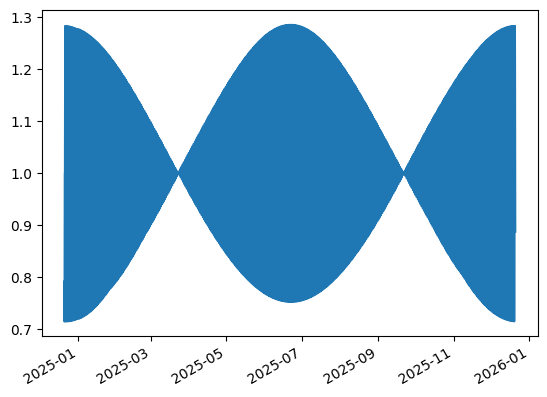

In [8]:
df['Second ajusted'].plot()

In [1]:
from timezonefinder import TimezoneFinder
from datetime import datetime
import pytz

def get_timezone_offset(latitude, longitude):
    """
    Obtenir le fuseau horaire GMT/UTC à partir de la latitude et de la longitude.
    """
    # Trouver le fuseau horaire
    tf = TimezoneFinder()
    timezone_str = tf.timezone_at(lat=latitude, lng=longitude)

    if timezone_str is None:
        return None, None

    # Récupérer le décalage UTC
    timezone = pytz.timezone(timezone_str)
    now = datetime.now(timezone)
    utc_offset = now.utcoffset().total_seconds() / 3600  # Décalage en heures

    return timezone_str, utc_offset

# Exemple d'utilisation
latitude = 48.8566  # Latitude de Paris
longitude = 2.3522  # Longitude de Paris

timezone_str, utc_offset = get_timezone_offset(latitude, longitude)

if timezone_str:
    print(f"Timezone: {timezone_str}")
    print(f"UTC Offset: GMT {utc_offset:+.1f}")
else:
    print("Impossible de déterminer le fuseau horaire.")


Timezone: Europe/Paris
UTC Offset: GMT +1.0


In [2]:
utc_offset

1.0